## 5.4 自注意力机制

在深度学习中，我们经常使用卷积神经网络（CNN）或循环神经网络（RNN）对序列进行编码。 有了注意力机制之后，我们将**词元序列**输入注意力池化中， 以便同一组词元**同时**充当查询、键和值。 具体来说，每个查询都会关注所有的键－值对并生成一个注意力输出。 由于查询、键和值来自同一组输入，因此被称为*自注意力*（self-attention）。

In [19]:
import math
import torch
from torch import nn
from d2l import torch as d2l

### 5.4.1 多头注意力(Multihead Attention)

* 对一个key，value，query，希望抽取**不同的信息**（类似CNN不同的通道）
  * 例如短距离关系和长距离关系
* 多头注意力使用$h$个独立的注意力池化层
  * 合并各个head输出得到最后输出

![image-20220215231249359](https://s2.loli.net/2022/02/15/WNorP6qkIUmJfYb.png)

在Transformer架构当中，多头注意力的位置为：
![image-20220215231706653](https://s2.loli.net/2022/02/15/YUKnBIS6fVWgdsA.png)


下面先通过数学语言来对多头注意力机制进行描述:

给定查询$\mathbf{q} \in \mathbb{R}^{d_q}$、键$\mathbf{k} \in \mathbb{R}^{d_k}$和值$\mathbf{v} \in \mathbb{R}^{d_v}$，每个注意力头$\mathbf{h}_i$（$i = 1, \ldots, h$）的计算方法为：

$$\mathbf{h}_i = f(\mathbf W_i^{(q)}\mathbf q, \mathbf W_i^{(k)}\mathbf k,\mathbf W_i^{(v)}\mathbf v) \in \mathbb R^{p_v},$$

其中，可学习的参数包括$\mathbf W_i^{(q)}\in\mathbb R^{p_q\times d_q}$、$\mathbf W_i^{(k)}\in\mathbb R^{p_k\times d_k}$和$\mathbf W_i^{(v)}\in\mathbb R^{p_v\times d_v}$，以及代表注意力汇聚的函数$f$。

$f$可以是式子中的加性注意力和缩放点积注意力。多头注意力的输出需要经过另一个线性转换，它对应着$h$个头连结后的结果，因此其可学习参数是$\mathbf W_o\in\mathbb R^{p_o\times h p_v}$：

$$\mathbf W_o \begin{bmatrix}\mathbf h_1\\\vdots\\\mathbf h_h\end{bmatrix} \in \mathbb{R}^{p_o}.$$

基于这种设计，每个头都可能会关注输入的不同部分，可以表示比简单加权平均值更复杂的函数。

`Pytorch`实现多头注意力：

在实现过程中，我们**选择缩放点积注意力作为每一个注意力头**。

为了避免计算代价和参数代价的大幅增长，我们设定$p_q = p_k = p_v = p_o / h$。值得注意的是，如果我们将查询、键和值的线性变换的输出数量设置为$p_q h = p_k h = p_v h = p_o$，则可以并行计算$h$个头。在下面的实现中，$p_o$是通过参数`num_hiddens`指定的。

In [20]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

为了能够**使多个头并行计算**，
上面的`MultiHeadAttention`类将使用下面定义的两个转置函数。
具体来说，`transpose_output`函数反转了`transpose_qkv`函数的操作。

In [21]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

下面通过例子来测试我`MultiHeadAttention`类。
多头注意力输出的形状是（`batch_size`，`num_queries`，`num_hiddens`）。

In [22]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [23]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

**总结一下：**
* 多头注意力融合了来自于多个注意力汇聚的不同知识，这些知识的不同来源于相同的查询、键和值的不同的子空间表示。
* 基于适当的张量操作，可以实现多头注意力的并行计算。

### 5.4.2 自注意力
* 给定序列$\mathbf{x}_{1}, \ldots, \mathbf{x}_{n}, \forall \mathbf{x}_{i} \in \mathbb{R}^{d}$

* 自注意力池化层将$\mathbf{x_i}$当做key,value,query来对序列抽取特征得到$\mathbf{y_1,...,y_n}$,则$\mathbf{y}_{i}=f\left(\mathbf{x}_{i},\left(\mathbf{x}_{1}, \mathbf{x}_{1}\right), \ldots,\left(\mathbf{x}_{n}, \mathbf{x}_{n}\right)\right) \in \mathbb{R}^{d}$

![image-20220214164927747](https://s2.loli.net/2022/02/14/2cKaRw5x7pXvYHs.png)


**对比CNN与RNN：**
* **CNN**就把序列当做1维输入，1D卷积进来，每个元素特征当做channels

![image-20220214165538687](https://s2.loli.net/2022/02/14/1WUZtoxOz7Bpw5u.png)

* **RNN**对序列的记忆很好
* **自注意力**如果句子长的话，计算复杂度会比较大，但并行度很高。非常适合**TPU**来进行计算。很适合计算长文本(Transformer，BERT，GPT)
  * 擅长处理长文本
  * 但计算开销比较贵

![image-20220214165603805](https://s2.loli.net/2022/02/14/QEkMwmSXpOxnKhJ.png)

* $k$是窗口的大小，一次看一个窗口
* 最长路径在CV中也叫作视野

下面通过代码测试一下注意力机制：（基于5.4.1实现）

In [24]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [25]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

### 5.4.3 位置编码(position encoding)

* 跟CNN/RNN不同， 自注意力并没有记录位置信息
* 位置编码将位置信息注入到**输入**里
  * 假设长度为$n$的序列是$\mathbf{X} \in \mathbb{R}^{n \times d}$，那么位置编码矩阵$\mathbf{P} \in \mathbb{R}^{n \times d}$来输出$\mathbf{X + P}$作为自编码输入
* $\mathbf{P}$的元素如下计算：

$$
p_{i, 2 j}=\sin \left(\frac{i}{10000^{2 j / d}}\right), \quad p_{i, 2 j+1}=\cos \left(\frac{i}{10000^{2 j / d}}\right)
$$

![image-20220214173138599](https://s2.loli.net/2022/02/14/uNVOYgmwoBWQrSE.png)

**相对位置信息**
>为什么要这样子编码呢？

* 位置位于$i + \delta$处的位置编码可以先行投影位置$i$处的位置编码来表示
* 记$w_j = \frac{1} {10000^{\frac{2j}{d}}}$,那么：

$$\left[\begin{array}{cc}
\cos \left(\delta \omega_{j}\right) & \sin \left(\delta \omega_{j}\right) \\
-\sin \left(\delta \omega_{j}\right) & \cos \left(\delta \omega_{j}\right)
\end{array}\right]\left[\begin{array}{c}
p_{i, 2 j} \\
p_{i, 2 j+1}
\end{array}\right]=\left[\begin{array}{c}
p_{i+\delta, 2 j} \\
p_{i+\delta, 2 j+1}
\end{array}\right]
$$

可以看到：投影矩阵$\left[\begin{array}{cc}
\cos \left(\delta \omega_{j}\right) & \sin \left(\delta \omega_{j}\right) \\
-\sin \left(\delta \omega_{j}\right) & \cos \left(\delta \omega_{j}\right)
\end{array}\right]$与$i$无关。


下面通过代码来实现位置编码：

In [26]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)  # dropout避免对P太过敏感

In [27]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]  # 保证P和X的维度是完全一致的，因为要相加
X.shape, P.shape, pos_encoding.P.shape

(torch.Size([1, 60, 32]), torch.Size([1, 60, 32]), torch.Size([1, 1000, 32]))

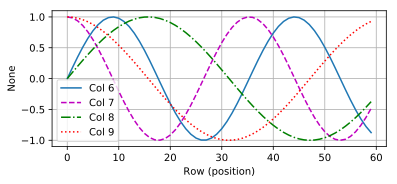

In [28]:
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)', figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

### 5.4.4 总结

* 自注意力池化层将$x$当做key, value,query来对序列抽取特征。
* 卷积神经网络和自注意力都拥有并行计算的优势，而且自注意力的最大路径长度最短。但是因为其*计算复杂度是关于序列长度的二次方*，所以在**很长的序列中计算会非常慢**。
* 位置编码在**输入**中加入位置信息，使得自注意力能够记忆位置信息。